In [1]:
import logging
import os
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel(logging.ERROR)
import keras
from clear_folder import clear_folder
from keras.models import load_model
from IPython.display import Image as imgdisp, display
from skimage.transform import resize
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2
from keras.utils import img_to_array, load_img



# Define the paths to the folders and the weights file
effected_folder = '/home/abidhasan/Documents/Indicate_FH/data/effected'
not_effected_folder = '/home/abidhasan/Documents/Indicate_FH/data/not_effected'
weights_path = '/home/abidhasan/Documents/Indicate_FH/saved_model/vgg16_300.h5'

# Image Size
size = 299
n_channels = 3

# Function to preprocess images
affected_img1 = "/home/abidhasan/Documents/Indicate_FH/train_val_test/test/effected/001_CLE204_Baseline_111.png"
affected_img2 = "/home/abidhasan/Documents/Indicate_FH/data/effected/001_CLE114_Baseline_112.png"
affected_img3 = "/home/abidhasan/Documents/Indicate_FH/data/effected/007_CLE203_Weizen_114.png"
affected_img4 = "/home/abidhasan/Documents/Indicate_FH/data/effected/CLE101_Baseline_Reaktion_CLE101_Baseline_Reaktion_3.png"
non_affected_img = "/home/abidhasan/Documents/Indicate_FH/train_val_test/test/not_effected/001_CLE197_Baseline_4.png"

2024-06-06 15:22:18.110271: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-06 15:22:18.129638: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-06 15:22:18.457701: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


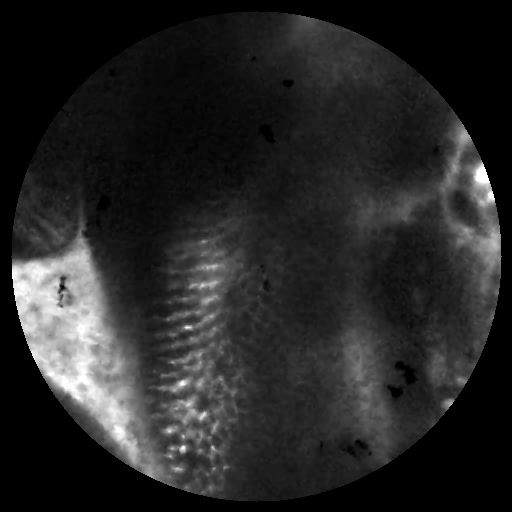

In [2]:
display(imgdisp(affected_img1))

In [3]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(
            last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [4]:
model = load_model('/home/abidhasan/Documents/Indicate_FH/saved_model/xception_100.h5')
model.summary()

2024-06-06 15:22:26.345278: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-06 15:22:26.357823: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-06 15:22:26.357943: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 20,863,529
Trainable params: 20,809,001
Non-trainable params: 54,528
_________________________________________________________________


In [ ]:
last_conv_layer_name = "block3_sepconv2_act"

# Remove last layer's softmax
model.layers[-1].activation = None

In [9]:
img_array = get_img_array(affected_img1, size=(size, size))

In [10]:
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

ValueError: No such layer: block3_sepconv2_act. Existing layers are: ['input_2', 'xception', 'global_average_pooling2d', 'dense'].